In [1]:
import os  
import random
import time

import pandas as pd
import numpy as np
import tensorflow as tf

import tensorflow.keras as keras
from tensorflow.keras.utils import Sequence

import scipy.sparse as sp
from scipy.sparse import csr_matrix
from sklearn.metrics import accuracy_score

os.environ["CUDA_VISIBLE_DEVICES"]="-1"  

In [2]:
# load the graph

data_folder_path = os.path.join(os.getcwd(),'data')
data_path = os.path.join(data_folder_path, 'DG-Miner_miner-disease-gene.tsv')

data = pd.read_csv(data_path, sep='\t', header=0, names=['diseases','genes'])
num_edges = data.shape[0]

In [3]:
'''
Even if we don't use features of nodes here, we're loading the data relative to features: there are some noeds that we have to remove because we removed them from the training that uses features, and in order to compare more properly the two models we need to have the same split of data.
'''


#data_small_path = os.path.join(data_folder_path, 'curated_gene_disease_associations.tsv')

diseases_similarities_path = os.path.join(data_folder_path, 'disease-disease_similarities.txt') 
diseases_similarities = pd.read_csv(diseases_similarities_path, sep='\t', names=['disease1','disease2','similarity'], index_col=False)

genes_order_path = os.path.join(data_folder_path, 'genes_order.txt')
genes_similarities_path = os.path.join(data_folder_path, 'genes_feature_matrix.npy')


# load dense feature matrix of the genes. Each row is a gene and each column contains its degree of similarity (from 0 to 1) with any other gene
genes_similarity_matrix_to_order = np.load(genes_similarities_path)


# list with the genes in the same order they are in the similarity matrix
with open(genes_order_path, 'r') as fin:
    genes_to_order = [elem.strip() for elem in fin]


diseases_similarities = diseases_similarities[diseases_similarities.similarity != 0]
diseases_similarities = diseases_similarities.reset_index(drop=True)
diseases_present = set([elem for elem in pd.concat([diseases_similarities.disease1, diseases_similarities.disease2])])

In [4]:
# establish the order of genes and diseases in matrices
diseases = sorted(set(data['diseases']))
genes = sorted(set(data['genes']))

# the first disease is a wrong value, and we remove it along with the corresponding gene
d1 = diseases.pop(0)
g1 = data[data.diseases == d1]['genes'].tolist()[0]
genes.remove(g1)

data = data[data.diseases != d1]
data = data.reset_index(drop=True)

num_diseases = len(diseases)
num_genes = len(genes)

print("Total number of genes is {} and total number of diseases is {}".format(num_genes, num_diseases))

# remove diseases and genes we don't have informations about
genes_copy = genes.copy()

for gene in genes_copy:
    if gene not in genes_to_order:
        genes.remove(gene)

# remove OMIM and MESH prefixes
diseases = [disease.split(':')[1] for disease in diseases]

diseases_copy = diseases.copy()

for disease in diseases_copy:
    if disease not in diseases_present:
        diseases.remove(disease)

num_genes = len(genes)
num_diseases = len(diseases)
print("After removing nodes we don't have informations about, we have {} genes and {} diseases".format(num_genes, num_diseases))

Total number of genes is 17821 and total number of diseases is 5663
After removing nodes we don't have informations about, we have 16646 genes and 5289 diseases


In [5]:
# sample nodes, not edges, because we have to reduce the size of similarity matrices
random.seed(45)


def sample_data(p, genes, diseases):
    sampled_diseases = []
    for disease in diseases:
        i = random.random()
        if i>p:
            sampled_diseases.append(disease)
    sampled_genes = []
    for gene in genes:
        i = random.random()
        if i>p:
            sampled_genes.append(gene)
    return sampled_genes, sampled_diseases

genes, diseases = sample_data(0.75, genes, diseases)
num_genes = len(genes)
num_diseases = len(diseases)
num_nodes = num_diseases + num_genes
print("After sampling we have left {} genes and {} diseases".format(num_genes, num_diseases))

After sampling we have left 4113 genes and 1344 diseases


In [6]:
genes_dict = {genes[idx]:idx for idx in range(num_genes)}
diseases_dict = {diseases[idx]:idx for idx in range(num_diseases)}

nodes_dict = genes_dict.copy()
for key in diseases_dict:
    nodes_dict[key] = diseases_dict[key]+num_genes

In [7]:
# creating an adjacency matrix with the genes on the rows and the diseases on the columns

# creating an adjacency matrix with the genes on the rows and the diseases on the columns

def create_adj(data, nodes_dict, num_nodes):

    num_edges = 0

    row = []
    col = []
    for idx in range(len(data)):
        
        disease = data['diseases'][idx].split(':')[1]
        gene = data['genes'][idx]

        gene_idx = nodes_dict.get(gene)
        disease_idx = nodes_dict.get(disease)

        if gene_idx == None or disease_idx == None:
            continue
        
        row.append(gene_idx)
        col.append(disease_idx)

        row.append(disease_idx)
        col.append(gene_idx)

        num_edges += 1

    row = np.array(row)
    col = np.array(col)
    values = np.ones(len(row))

    adj = csr_matrix( (values, (row, col)), shape = (num_nodes, num_nodes) )
    print("The number of edges was {} and now is {}".format(len(data), num_edges))
    return adj

adj = create_adj(data, nodes_dict, num_nodes)

The number of edges was 15509618 and now is 926967


In [8]:
def train_test_split(adj, num_genes, train_ratio=0.01, test_ratio=0.01):

    num_nodes = adj.shape[0] 
    
    # get upper triangular matrix (without the main diagonal, so k=1, otherwise 0)
    adj_triu = sp.triu(adj, k=1)
    
    # return row and col indices of non-zero values in net_triu
    row, col, _ = sp.find(adj_triu)
    
    # randomly permute edges
    perm = np.random.permutation(len(row))
    row, col = row[perm], col[perm]
    
    # sample train and test true positive links
    split = int(len(row) * (1 - test_ratio - train_ratio))
    adj_train_edges = (row[:split], col[:split])
    rest_edges = (row[split:], col[split:])

    adj_train_values = np.ones(len(adj_train_edges[0]))
    adj_train = csr_matrix( (adj_train_values, adj_train_edges), shape=(num_nodes, num_nodes) )

    # insert negative edges
    num_to_insert = len(rest_edges[0])

    # We could add a check to verify that there are actually num_to_insert negative edges to avoid an infinite loop
    # we should insert them checking directly where there is 0 in the adj matrix (but not in cells that refer to gene-gene links or disease-disease links)
    # In our case this is not necessary as the network is not as connected

    neg_edges = set()
    while len(neg_edges) < num_to_insert:

        i,j = random.randint(0, num_genes-1), random.randint(num_genes, num_nodes-1)
        if adj[i, j] == 0:
            neg_edges.add( (i,j) )
        else:
            continue

    row,col = [],[]
    for elem in neg_edges:
        row.append(elem[0])
        col.append(elem[1])
    
    neg_edges = ( np.array(row), np.array(col) )
    
    # now split the rest_set in two sets: 
    # - the set we will use to train 
    # - the set we will use to test
    split2 = int( len(rest_edges[0]) * (1- (test_ratio/(test_ratio+train_ratio))) )
    train_pos_edges = (rest_edges[0][:split2], rest_edges[1][:split2])
    test_pos_edges = (rest_edges[0][split2:], rest_edges[1][split2:])
    train_neg_edges = (neg_edges[0][:split2], neg_edges[1][:split2])
    test_neg_edges = (neg_edges[0][split2:], neg_edges[1][split2:])
    
    assert(len(train_pos_edges[0]) == len(train_neg_edges[0])), 'Wrong number of negative edges added!'
    assert(len(test_pos_edges[0]) == len(test_neg_edges[0])), 'Wrong number of negative edges added!'

    train_edges = ( np.hstack((train_pos_edges[0], train_neg_edges[0])), np.hstack((train_pos_edges[1], train_neg_edges[1])) )
    test_edges = ( np.hstack((test_pos_edges[0], test_neg_edges[0])), np.hstack((test_pos_edges[1], test_neg_edges[1])) )

    train_labels = np.hstack( (np.ones(len(train_pos_edges[0])), np.zeros(len(train_neg_edges[0]))) )
    test_labels = np.hstack( (np.ones(len(test_pos_edges[0])),  np.zeros(len(test_neg_edges[0]))) )

    perm_train = np.random.permutation(len(train_labels))
    perm_test = np.random.permutation(len(test_labels))

    train_edges = (train_edges[0][perm_train], train_edges[1][perm_train])
    train_labels = train_labels[perm_train]

    test_edges = (test_edges[0][perm_test], test_edges[1][perm_test])
    test_labels = test_labels[perm_test]
    

    # return indices not as tuples of lists but instead as matrices with the indices of each edge in the rows in order to feed them to a keras generator

    train_edges = np.matrix( np.vstack((np.array(train_edges[0]), np.array(train_edges[1]))) ).transpose()
    test_edges = np.matrix( np.vstack((np.array(test_edges[0]), np.array(test_edges[1]))) ).transpose()


    return adj_train, train_edges, train_labels, test_edges, test_labels

In [9]:

# noise_shape is [num_nonzero_elements], namely it is a list containing the number of elements of the sparse tensor
# keep_prob is 1-dropout_rate 
# inputs is the sparse tensor which we are applying dropout to
def dropout_sparse(inputs, keep_prob, noise_shape):
    keep_tensor = keep_prob + tf.random.uniform(noise_shape)
    to_retain = tf.cast(tf.floor(keep_tensor), dtype=tf.bool)
    out = tf.sparse.retain(inputs, to_retain=to_retain)

    # the elements of the tensor are rescaled after dropout
    return out * (1/keep_prob)

In [10]:
class GraphSparseConvolution(tf.keras.layers.Layer):
    # the graph takes as input the adjacency matrix in the form of a sparse tensor
    # it is important that the type of the elements of the tensor are explicitly converted to floats
    def __init__(self, adj_norm, output_size=32, dropout_rate=0.0, act=tf.nn.relu):
        super(GraphSparseConvolution, self).__init__()
        self.adj_norm = adj_norm
        self.output_size = output_size
        self.dropout_rate = dropout_rate
        self.act = act


    # input_shape here will be automatically set as the shape of the input tensor, that will be the feature matrix
    def build(self, input_shape):
        init = tf.keras.initializers.GlorotNormal(seed=None)
        self.kernel = self.add_weight('kernel', initializer=init, shape=[int(input_shape[-1]),self.output_size])

    # the input is a sparse tensor whose elements have been explicitly converted to floats
    def call(self, inputs):
        x = dropout_sparse(inputs, 1-self.dropout_rate, [len(inputs.values)])
        x = tf.sparse.sparse_dense_matmul(x, self.kernel)
        x = tf.sparse.sparse_dense_matmul(self.adj_norm, x)
        outputs = self.act(x)
        return outputs


# the only difference between these two classes is that the first will treat also the features as a sparse matrix (the adjacency matrix will always be sparse)
class GraphConvolution(tf.keras.layers.Layer):
    def __init__(self, adj_norm, output_size=32, dropout_rate=0.0, act=tf.nn.relu):
        super(GraphConvolution, self).__init__()
        self.adj_norm = adj_norm
        self.output_size = output_size
        self.dropout_rate = dropout_rate
        self.act= act
    
    def build(self, input_shape):
        init = tf.keras.initializers.GlorotNormal(seed=None)
        self.kernel = self.add_weight('kernel', initializer=init, shape=[int(input_shape[-1]),self.output_size])


    # the input to the call function is a dense tensor whose elements have been explicitly converted to floats
    def call(self, inputs):
        x = tf.keras.layers.Dropout(rate=self.dropout_rate)(inputs)
        x = tf.matmul(x, self.kernel)
        x = tf.sparse.sparse_dense_matmul(self.adj_norm, x)
        outputs = self.act(x)
        return outputs
    

In [11]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def generate_edges(edges_to_predict):
    for elem in edges_to_predict:
        yield elem


def normalize_adj(adj):

    adj_I = adj + sp.eye(adj.shape[0])

    D = np.sum(adj_I, axis=1)
    D_power = sp.diags(np.asarray(np.power(D, -0.5)).reshape(-1))

    adj_norm = D_power.dot(adj_I).dot(D_power)

    return adj_norm


def convert_sparse_matrix_to_sparse_tensor(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    indices_matrix = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    sparse_tensor = tf.SparseTensor(indices=indices_matrix, values=values, dense_shape=shape)
    return tf.cast(sparse_tensor, dtype=tf.float32)



def predict_all_edges(edges_generator, embeddings, num_edges_at_once):
    outputs = tf.Variable([],dtype=tf.float32)
    num_batches = 0


    for elem in edges_generator.repeat(count=1).batch(num_edges_at_once).take(-1):

        # debug
        '''
        if num_batches%5 == 0:
            print("Processed {} edges".format(num_batches*batch_size))
        '''

        row = elem[:,0]
        col = elem[:,1]
        
        nodes_i = tf.gather(embeddings, row)
        nodes_j = tf.gather(embeddings, col)

        product = tf.matmul(nodes_i, nodes_j, transpose_b=True)
        predictions = tf.raw_ops.DiagPart(input=product)
        outputs = tf.concat([outputs, predictions], axis=0)

        num_batches += 1
    
    # just to underline that logits are before applying sigmoid
    logits = outputs
    return logits


# this function proceeds with the forward pass and computes the loss
def compute_test_metrics(model, inputs, edges_generator, labels, num_edges_at_once, training=False):
    # the model returns the computed embeddings
    embeddings = model(inputs, training=training)

    # compute the logits of the set we are using
    logits = predict_all_edges(edges_generator, embeddings, num_edges_at_once=num_edges_at_once)
    #logits = predict_edges(edges_generator, embeddings)

    # the loss function applies the sigmoid itself
    loss_value = loss_function(labels, logits).numpy()

    # now I apply the sigmoid to compute the accuracy score
    predictions = tf.nn.sigmoid(logits)
    acc_function = tf.keras.metrics.BinaryAccuracy()
    acc_function.update_state(labels, predictions)
    accuracy = acc_function.result().numpy()
    
    return loss_value, accuracy


def predict_edges_batch(edges, embeddings):
    
    # take the index of nodes on each side of the edges 
    row = edges[:,0]
    col = edges[:,1]
    
    # get the left-hand nodes (nodes_i) and the ight-hand nodes (nodes_j) with respect to each edge
    nodes_i = tf.gather(embeddings, row)
    nodes_j = tf.gather(embeddings, col)

    # multiply each node with its corresponding and everyone else (useless but needed) and then take only the diagonal
    # in which the embeddings of the nodes belonging to the same edge to predict have been multiplied
    product = tf.matmul(nodes_i, nodes_j, transpose_b=True)
    predictions = tf.raw_ops.DiagPart(input=product)
    
    # just to underline that we have logits before applying sigmoid
    logits = predictions
    
    return logits

# this function proceeds with the forward pass and computes the loss
def compute_train_metrics(model, inputs, edges, labels, training=True):
    # the model returns the computed embeddings
    embeddings = model(inputs, training=training)

    # compute the logits of the set we are using
    logits = predict_edges_batch(edges, embeddings)

    # the loss function applies the sigmoid itself, so we pass the logits
    loss_value = loss_function(labels, logits)
    
    return loss_value, logits

# this function computes the gradients using the loss function
def grad(model, inputs, edges, labels):
    with tf.GradientTape() as tape:
        loss, logits = compute_train_metrics(model, inputs, edges, labels, training=True)
    return loss, tape.gradient(loss, model.trainable_variables), logits




In [12]:
adj_train, train_edges, train_labels, test_edges, test_labels = train_test_split(adj, num_genes, train_ratio=0.1, test_ratio=0.1)


adj_norm = normalize_adj(adj_train)
adj_norm_tensor = convert_sparse_matrix_to_sparse_tensor(adj_norm)

In [13]:
LR = 0.005
DROPOUT = 0.0

model = tf.keras.Sequential([
    GraphSparseConvolution(adj_norm=adj_norm_tensor, output_size=64, dropout_rate=DROPOUT),
    GraphConvolution(adj_norm=adj_norm_tensor, output_size=64, dropout_rate=DROPOUT, act=tf.keras.activations.linear),
])


optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

train_loss_epochs = []
train_acc_epochs = []
test_loss_epochs = []
test_acc_epochs = []

In [14]:

num_epochs = 100
BATCH_SIZE = 10000
NUM_TEST_EDGES_AT_ONCE = 20000

# create test and train generators
# data train generator is actually an instance of td.data.Dataset, so its a dataset that is created from that generator function
data_train_generator = tf.data.Dataset.from_generator(generate_edges, args=[train_edges], output_types=tf.int32, output_shapes=(2,))
data_test_generator = tf.data.Dataset.from_generator(generate_edges, args=[test_edges], output_types=tf.int32, output_shapes=(2,))



print("Num edges to process for each epoch is {}".format(len(train_edges)))

inputs_tensor = convert_sparse_matrix_to_sparse_tensor(sp.identity(num_nodes))


for epoch in range(num_epochs):

    start_epoch = time.time()
    
    # initialize a tensor that will contain the logits of the entire epoch
    logits = tf.Variable([], dtype=tf.float32)
    train_loss = 0

    batch_num = 0
    for batch in data_train_generator.repeat(count=1).batch(BATCH_SIZE).take(-1):


        # select a subset of edges and labels 
        batch_edges = batch
        batch_labels = train_labels[batch_num*BATCH_SIZE:(batch_num+1)*BATCH_SIZE]

        loss_batch, gradients_batch, logits_batch = grad(model, inputs_tensor, batch_edges, batch_labels)
        optimizer.apply_gradients(zip(gradients_batch, model.trainable_variables))

        logits = tf.concat([logits, logits_batch], axis=0)

        # compute the entire train_loss by summing the loss of each step
        train_loss += loss_batch.numpy()

        
        batch_num +=1
    
    train_loss = train_loss / batch_num

    # compute the train accuracy using the tensor of all logits and all labels
    acc_function = tf.keras.metrics.BinaryAccuracy()
    acc_function.update_state(train_labels, tf.nn.sigmoid(logits))
    train_accuracy = acc_function.result().numpy()

    test_loss, test_accuracy = compute_test_metrics(model, inputs_tensor, data_test_generator, test_labels, num_edges_at_once=NUM_TEST_EDGES_AT_ONCE)

    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_accuracy)
    test_loss_epochs.append(test_loss)
    test_acc_epochs.append(test_accuracy)

    # considering both train and test time
    stop_epoch = time.time()
    optimization_step = optimizer.iterations.numpy()

    if epoch == 0:
        print(model.summary())
        print('\n====================== Start training ======================\n')
    
    print("Epoch number: {}\toptimization step: {}\telapsed time: {}".format(epoch, optimization_step, stop_epoch-start_epoch))
    print("Train Loss: {}\tTrain accuracy: {:.4f}".format(train_loss, train_accuracy))
    print("Valid Loss: {}\tValid accuracy: {:.4f}".format(test_loss, test_accuracy))



me: 21.700705528259277
Train Loss: 0.16540542323338359	Train accuracy: 0.9302
Valid Loss: 0.1968752145767212	Valid accuracy: 0.9204
Epoch number: 46	optimization step: 893	elapsed time: 21.706432104110718
Train Loss: 0.1640097106757917	Train accuracy: 0.9304
Valid Loss: 0.196624755859375	Valid accuracy: 0.9207
Epoch number: 47	optimization step: 912	elapsed time: 21.722282648086548
Train Loss: 0.16266645804831856	Train accuracy: 0.9311
Valid Loss: 0.19697290658950806	Valid accuracy: 0.9207
Epoch number: 48	optimization step: 931	elapsed time: 21.53645634651184
Train Loss: 0.1614505272162588	Train accuracy: 0.9316
Valid Loss: 0.19674593210220337	Valid accuracy: 0.9208
Epoch number: 49	optimization step: 950	elapsed time: 21.521254777908325
Train Loss: 0.16041751990192815	Train accuracy: 0.9319
Valid Loss: 0.1966177076101303	Valid accuracy: 0.9212
Epoch number: 50	optimization step: 969	elapsed time: 21.58030652999878
Train Loss: 0.15955789622507596	Train accuracy: 0.9321
Valid Loss: 0.1

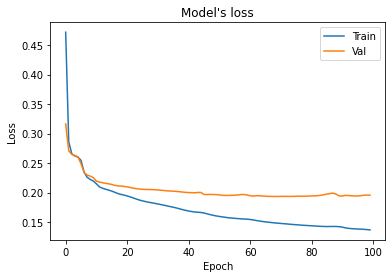

In [15]:
from matplotlib import pyplot as plt

plt.plot(train_loss_epochs)
plt.plot(test_loss_epochs)

plt.title("Model's loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

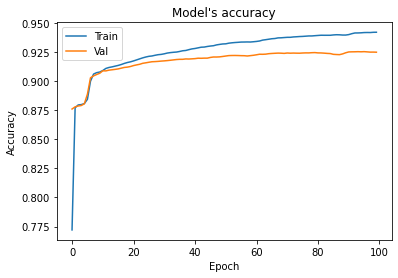

In [16]:
plt.plot(train_acc_epochs)
plt.plot(test_acc_epochs)

plt.title("Model's accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()